In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import nibabel as nib

from src.torch.reg import register_sequence

In [3]:
def crop_center(im, crx=64, cry=64):
    """Center crop the image"""
    y, x = im.shape[-2:]
    sx = x // 2 - (crx // 2)
    sy = y // 2 - (cry // 2)
    return im[..., sy : sy + cry, sx : sx + crx]

In [5]:
"""Download patient001 data from ACDC and place it in /data/external/ACDC/"""
f_im = r"../data/external/ACDC/patient001_4d.nii.gz"
im4d = nib.load(f_im).get_fdata().astype(np.uint16) 

In [6]:
szy, szx, nsl, nfr = im4d.shape

ims = im4d[:,:,5,:]

ims = crop_center(np.transpose(ims, axes=(2, 0, 1)), 128, 96)

print(ims.shape)

(30, 96, 128)


In [7]:
class RegParam:
    """Define registration parameters"""

    def __init__(
        self,
        mx_iter=20.0,
        t=0.5,
        t_up=1.0,
        t_dn=2.0 / 3.0,
        mn_t=0.01,
        j_lb=0.25,
        j_ub=4.0,
    ):
        self.mx_iter = mx_iter
        self.t = t
        self.t_up = t_up
        self.t_dn = t_dn
        self.mn_t = mn_t
        self.j_lb = j_lb
        self.j_ub = j_ub

In [8]:
def griddata_1d(nx, ny, V):
    m, n = V.shape

    rx = np.clip(ny, 0, m - 1.0)
    ry = np.clip(nx, 0, n - 1.0)
    frx = np.floor(rx).astype(np.int)
    fry = np.floor(ry).astype(np.int)

    frx[np.equal(frx, rx)] = frx[np.equal(frx, rx)] - 1
    fry[np.equal(fry, ry)] = fry[np.equal(fry, ry)] - 1

    crx = np.clip(frx + 1, 0, m - 1.0).astype(np.int)
    cry = np.clip(fry + 1, 0, n - 1.0).astype(np.int)

    res = (
        V[frx, fry] * (crx - rx) * (cry - ry)
        + V[frx, cry] * (crx - rx) * (ry - fry)
        + V[crx, fry] * (rx - frx) * (cry - ry)
        + V[crx, cry] * (rx - frx) * (ry - fry)
    )

    return res

In [9]:
def get_pointcorrespondence_mesh(dm_fx, dm_fy, dm_bx, dm_by, bb, pts, nframes):

    iuf, ivf = pts[:, 0], pts[:, 1]
    iub, ivb = iuf, ivf
    contour_f, contour_b, contour = {}, {}, {}

    for k in range(nframes):
        if k > 0:
            ix = griddata_1d(
                (iuf - bb[0]).astype(np.float32),
                (ivf - bb[2]).astype(np.float32),
                (dm_fy[:, :, k - 1]).astype(np.float32),
            )
            iy = griddata_1d(
                (iuf - bb[0]).astype(np.float32),
                (ivf - bb[2]).astype(np.float32),
                (dm_fx[:, :, k - 1]).astype(np.float32),
            )
            iuf, ivf = iuf + ix, ivf + iy

            ix = griddata_1d(
                (iub - bb[0]).astype(np.float32),
                (ivb - bb[2]).astype(np.float32),
                (dm_by[:, :, k - 1]).astype(np.float32),
            )
            iy = griddata_1d(
                (iub - bb[0]).astype(np.float32),
                (ivb - bb[2]).astype(np.float32),
                (dm_bx[:, :, k - 1]).astype(np.float32),
            )
            iub, ivb = iub + ix, ivb + iy

            contour_b[nframes - k] = np.vstack([iub, ivb])
            contour_f[k] = np.vstack([iuf, ivf])

    contour_b[0] = np.vstack([pts[:, 0], pts[:, 1]])
    contour_f[0] = np.vstack([pts[:, 0], pts[:, 1]])

    for k in range(nframes):
        w = 1.0 * (k + 1) / (1.0 * nframes)
        contour[k] = (1 - w) * contour_f[k] + w * contour_b[k]

    return contour

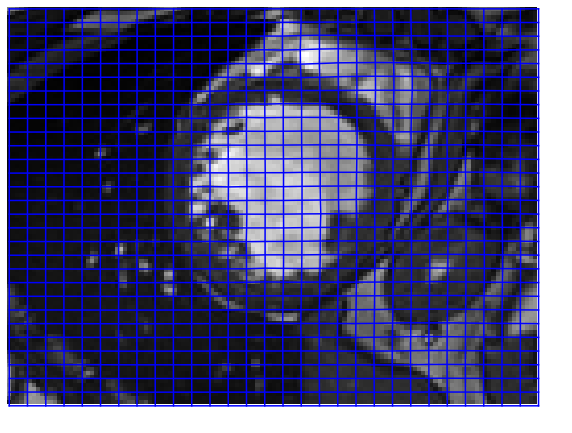

1 loop, best of 1: 1min 3s per loop


In [10]:
%%timeit -n 1 -r 1

def test_torch(ims):
    """Example code for image registration"""

    
    
    ims = np.array(ims, dtype=np.float64)
    print(ims.shape)    
    
    ims = np.transpose(ims, axes=(1, 2, 0))

    bb = [0, ims.shape[1], 0, ims.shape[0]]

    reg_prm = RegParam()

    stime = time.time()
    def_fields_f, def_fields_b = register_sequence(
        ims, prm=reg_prm
    )

    print(time.time() - stime)

    dm_fx, dm_fy, dm_bx, dm_by = (
        def_fields_f[:, :, :, 1],
        def_fields_f[:, :, :, 0],
        def_fields_b[:, :, :, 1],
        def_fields_b[:, :, :, 0],
    )

    meshpts = np.meshgrid(
        np.linspace(0, ims.shape[1], 30), np.linspace(0, ims.shape[0], 30),
    )
    mesh = get_pointcorrespondence_mesh(
        dm_fx,
        dm_fy,
        dm_bx,
        dm_by,
        bb,
        pts=np.vstack([meshpts[0].flatten(), meshpts[1].flatten()]).T,
        nframes=ims.shape[-1],
    )

    for _ in range(5):
        for t in range(ims.shape[-1]):
            mesh_cx = np.reshape(mesh[t][0, :], (30, 30), order="A")
            mesh_cy = np.reshape(mesh[t][1, :], (30, 30), order="A")
            clear_output(wait=True)
            plt.figure(figsize=(10,10))
            plt.imshow(ims[:, :, t], cmap="gray")
            plt.plot(mesh_cx, mesh_cy, "b")
            plt.plot(mesh_cx.T, mesh_cy.T, "b")
            plt.axis("off")
            plt.pause(0.01)


test_torch(ims)            